## Import des librairies

In [5]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from nltk.translate import bleu_score
from rouge_score import rouge_scorer
import json

from metrics.Bary_score import BaryScoreMetric
from metrics.InfoLM import InfoLM
from metrics.Depth_score import DepthScoreMetric
from metrics.WBleu import WeightedEntropyBLEU

    
from rouge import Rouge
from sacrebleu import corpus_bleu
from bert_score import score as bert_score
import nltk

# nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
# from moverscore import get_idf_dict, word_mover_score

c:\Users\coren\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
import warnings
warnings.filterwarnings('ignore')

# MANS Dataset

## Computation des métriques

In [24]:

def compute_metrics(dataset, gen):
    
    if gen not in ['gpt', 'plan_write', 's2s', 'gpt_kg', 'fusion']:
        raise ValueError("Le générateur doit être 'gpt', 'plan_write', 's2s', 'gpt_kg' ou 'fusion'.")
    
    # Initialisation du corpus de référence pour la métrique WeightedEntropyBLEU
    reference_corpus = [data['gold_response'] for id, data in dataset.items()]
    
    # Initialisation des instances calculant les métriques
    weighted_entropy_bleu = WeightedEntropyBLEU(reference_corpus)
    rouge = Rouge()
    model_name = 'distilbert-base-uncased'
    bary_score_metric = BaryScoreMetric(model_name ,use_idfs=False)
    info_lm_metric = InfoLM(model_name, measure_to_use='kl', alpha=0.25, beta=0.25, temperature=1, use_idf_weights=False)
    depth_score_metric = DepthScoreMetric(model_name, layers_to_consider=4)

    # Initialisation des listes de stockages de calcul des métriques
    bleu_scores = []
    weighted_bleu_scores = []
    rouge_1_r = []
    rouge_1_p = []
    rouge_1_f = []
    rouge_2_r = []
    rouge_2_p = []
    rouge_2_f = []
    rouge_l_r = []
    rouge_l_p = []
    rouge_l_f = []
    bertscore_p = []
    bertscore_r = []
    bertscore_f1 = []
    # moverscores = []
    bary_scores_W = []
    bary_scores_SD_10 = []
    bary_scores_SD_5 = []
    bary_scores_SD_1 = []
    bary_scores_SD_0_5 = []
    bary_scores_SD_0_1 = []
    bary_scores_SD_0_01 = []
    bary_scores_SD_0_001 = []
    info_lm_kl = []
    info_lm_r_kl = []
    info_lm_sim_kl = []
    depth_scores = []
    human_scores = []
    
    

    # Itération sur le dataset et mise en place des métriques de comparaison entre les réponses aux prompt de générateurs par rapport à la gold réponse
    for id, data in dataset.items():
        gold_response = data['gold_response']
        response = data['gen'][gen]['text']
        human_score = np.mean(data['gen'][gen]['score'])
        human_scores.append(human_score)
        
        # Tokenisation des réponses
        t_gold_response = bary_score_metric.tokenizer(gold_response, return_tensors='pt')['input_ids']
        t_response = bary_score_metric.tokenizer(response, return_tensors='pt')['input_ids']

        # Convertion token IDs en strings
        t_gold_response_str = ' '.join(bary_score_metric.tokenizer.convert_ids_to_tokens(t_gold_response[0]))
        t_response_str = ' '.join(bary_score_metric.tokenizer.convert_ids_to_tokens(t_response[0]))
        
        # Tokenisation des phrases en listes de mots pour computer BLEU
        hyp_tokens = word_tokenize(t_response_str)
        ref_tokens = word_tokenize(t_gold_response_str)
        
        # Calcul des différents scores de métriques
        bleu_score = sentence_bleu([ref_tokens], hyp_tokens)
        bleu_scores.append(bleu_score)
        
        entropy_bleu_score = weighted_entropy_bleu.score([ref_tokens], hyp_tokens)
        weighted_bleu_scores.append(entropy_bleu_score)

        rouge_scores = rouge.get_scores(t_response_str, t_gold_response_str, avg=True)
        rouge_1_r.append(rouge_scores['rouge-1']['r'])
        rouge_1_p.append(rouge_scores['rouge-1']['p'])
        rouge_1_f.append(rouge_scores['rouge-1']['f'])
        rouge_2_r.append(rouge_scores['rouge-2']['r'])
        rouge_2_p.append(rouge_scores['rouge-2']['p'])
        rouge_2_f.append(rouge_scores['rouge-2']['f'])
        rouge_l_r.append(rouge_scores['rouge-l']['r'])
        rouge_l_p.append(rouge_scores['rouge-l']['p'])
        rouge_l_f.append(rouge_scores['rouge-l']['f'])

        
        
        bary_score_metric.prepare_idfs([t_gold_response_str], [t_response_str])
        bary_score = bary_score_metric.evaluate_batch([t_gold_response_str], [t_response_str])
        info_lm_metric.prepare_idfs([t_gold_response_str], [t_response_str])
        info_lm_score = info_lm_metric.evaluate_batch([t_gold_response_str], [t_response_str])
        depth_score = depth_score_metric.evaluate_batch([t_gold_response_str], [t_response_str])

        bary_scores_W.append(bary_score['baryscore_W'][0])
        bary_scores_SD_10.append(bary_score['baryscore_SD_10'][0])
        bary_scores_SD_5.append(bary_score['baryscore_SD_5'][0])
        bary_scores_SD_1.append(bary_score['baryscore_SD_1'][0])
        bary_scores_SD_0_5.append(bary_score['baryscore_SD_0.5'][0])
        bary_scores_SD_0_1.append(bary_score['baryscore_SD_0.1'][0])
        bary_scores_SD_0_01.append(bary_score['baryscore_SD_0.01'][0])
        bary_scores_SD_0_001.append(bary_score['baryscore_SD_0.001'][0])
        info_lm_kl.append(info_lm_score['kl'][0])
        info_lm_r_kl.append(info_lm_score['r_kl'][0])
        info_lm_sim_kl.append(info_lm_score['sim_kl'][0])
        depth_scores.append(depth_score['depth_score'][0])
        
        P, R, F1 = bert_score([t_response_str], [t_gold_response_str], lang="en", model_type=model_name)
        bertscore_p.append(P.numpy()[0])
        bertscore_r.append(R.numpy()[0])
        bertscore_f1.append(F1.numpy()[0])
        
        # moverscore = word_mover_score([t_gold_response_str], [t_response_str], idf_dict_ref, stop_words=[], n_gram=1, remove_subwords=True)
        # moverscores.append(moverscore[0])
    


    dict = {
        'BLEU': bleu_scores,
        'Weighted_BLEU': weighted_bleu_scores,
        'Rouge_1_r': rouge_1_r,
        'Rouge_1_p': rouge_1_p,
        'Rouge_1_f': rouge_1_f,
        'Rouge_2_r': rouge_2_r,
        'Rouge_2_p': rouge_2_p,
        'Rouge_2_f': rouge_2_f,
        'Rouge_L_r': rouge_l_r,
        'Rouge_L_p': rouge_l_p,
        'Rouge_L_f': rouge_l_f,
        'Bary_W': bary_scores_W,
        'Bary_SD_10': bary_scores_SD_10,
        'Bary_SD_5': bary_scores_SD_5,
        'Bary_SD_1': bary_scores_SD_1,
        'Bary_SD_0_5': bary_scores_SD_0_5,
        'Bary_SD_0_1': bary_scores_SD_0_1,
        'Bary_SD_0_01': bary_scores_SD_0_01,
        'Bary_SD_0_001': bary_scores_SD_0_001,
        'InfoLM_kl': info_lm_kl,
        'InfoLM_r_kl': info_lm_r_kl,
        'InfoLM_sim_kl': info_lm_sim_kl,
        'Depth_scores': depth_scores,
        'Bertscore_p': bertscore_p,
        'Bertscore_r': bertscore_r,
        'Bertscore_f1': bertscore_f1,
        # 'moverscores': moverscores,
        'human_scores': human_scores
    }

    df = pd.DataFrame(dict)


    
    return df


# subset_size = 10
# subset_items = list(dataset.items())[:subset_size]

# # créer un dictionnaire à partir des paires clé-valeur
# subset = dict(subset_items)

# df = compute_metrics(subset, gen='gpt')
# print(df.corr())


## Computation des correlations

In [25]:
def compute_correlations(df, method='pearson', dataset_name='', gen='', save_path=None):
    if method not in ['pearson', 'spearman', 'kendall']:
        raise ValueError("La méthode doit être 'pearson', 'spearman' ou 'kendall'.")

    human_corr = df.corr(method=method)["human_scores"].drop("human_scores")
    
    plt.figure(figsize=(20, 1))
    sns.heatmap(human_corr.to_frame().T, annot=True, cmap="coolwarm", vmin=-1, vmax=1, cbar=False)

    method_capitalized = method.capitalize()
    plt.title(f"Correlations with human_score ({method_capitalized}) - Dataset: {dataset_name} - Gen: {gen}")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    plt.subplots_adjust(top=0.9, bottom=0.5)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Graphique enregistré sous : {save_path}")

    plt.show()

    return human_corr


## Itération des computations sur les deux dataset et pour les différents générateurs de texte

In [ ]:
dataset_roc_path = r"data/mans_data/mans_roc.json"
dataset_wp_path = r"data/mans_data/mans_wp.json"
datasets = { 'WP': dataset_wp_path}

gens = ['gpt', 'plan_write', 's2s', 'gpt_kg', 'fusion']

for dataset_name, dataset_path in datasets.items():
    print(f"Dataset: {dataset_name}")
    
    with open(dataset_path, 'r', encoding='utf-8') as f:
        dataset = json.load(f)

    for gen in gens:
        print(f"Generation: {gen}")
        
        # on effectue des subset car le code est trop lourd
        subset_size = 100
        subset_items = list(dataset.items())[:subset_size]

        # créer un dictionnaire à partir des paires clé-valeur
        subset = dict(subset_items)

        df = compute_metrics(subset, gen=gen)
        save_path = os.path.join('figures', f"{dataset_name}_{gen}_correlation.png")
        pearson_corr = compute_correlations(df, method='pearson', dataset_name=dataset_name, gen=gen, save_path=save_path)
        print("\n")


# HANNA Dataset

In [16]:
dataset_hanna_path = r"data\hanna\hanna_stories_annotations.csv"
data = pd.read_csv(dataset_hanna_path)
data.head()

,Story ID,Prompt,Human,Story,Model,Relevance,Coherence,Empathy,Surprise,Engagement,Complexity,Worker ID,Assignment ID,Work time in seconds,Name
0,0,When you die the afterlife is an arena where y...,"3,000 years have I been fighting. Every mornin...","3,000 years have I been fighting. Every mornin...",Human,4,4,3,2,4,4,A2VE5IV9OD2SK1,3X87C8JFVHIT235KQ4UTS8264I6SQJ,579.0,None
1,0,When you die the afterlife is an arena where y...,"3,000 years have I been fighting. Every mornin...","3,000 years have I been fighting. Every mornin...",Human,5,5,1,3,4,1,A1IZ4NX41GKU4X,3DR23U6WEGL5K0SU6D4J8W9EM9LTE7,82.0,none
2,0,When you die the afterlife is an arena where y...,"3,000 years have I been fighting. Every mornin...","3,000 years have I been fighting. Every mornin...",Human,2,2,3,2,2,3,A264NN7JBX4UDQ,3UJ1CZ6IZSW49HMM6C6QUX7F7UV5SA,273.0,none
3,1,A new law is enacted that erases soldiers memo...,"“Dad, you 're on TV again !” I heard Eric 's v...","“Dad, you 're on TV again !” I heard Eric 's v...",Human,5,5,3,4,4,4,A3CFNUD7VR2E1E,317HQ483IIZJ5SPW508YKC1EP6RINX,117.0,Eric
4,1,A new law is enacted that erases soldiers memo...,"“Dad, you 're on TV again !” I heard Eric 's v...","“Dad, you 're on TV again !” I heard Eric 's v...",Human,5,4,4,4,4,4,A2VE5IV9OD2SK1,3T3IWE1XGHUUH3IZF4ZJ2DYS57WQTT,751.0,Eric


## Computation des métriques

In [ ]:

def compute_metrics_hanna(csv_file):
    dataset = pd.read_csv(csv_file)

    # Supprimer les lignes où la colonne Model est égale à 'Human'
    dataset = dataset[dataset['Model'] != 'Human']

    # Supprimer les duplicats
    dataset = dataset.drop_duplicates()

    # Initialisation du corpus de référence pour la métrique WeightedEntropyBLEU
    reference_corpus = [data['Human'] for id, data in dataset.iterrows()]
    
    # Initialisation des instances calculant les métriques
    weighted_entropy_bleu = WeightedEntropyBLEU(reference_corpus)
    rouge = Rouge()
    model_name = 'distilbert-base-uncased'
    bary_score_metric = BaryScoreMetric(model_name ,use_idfs=False)
    info_lm_metric = InfoLM(model_name, measure_to_use='kl', alpha=0.25, beta=0.25, temperature=1, use_idf_weights=False)
    depth_score_metric = DepthScoreMetric(model_name, layers_to_consider=4)

    # Initialisation des listes de stockages de calcul des métriques
    bleu_scores = []
    weighted_bleu_scores = []
    rouge_1_r = []
    rouge_1_p = []
    rouge_1_f = []
    rouge_2_r = []
    rouge_2_p = []
    rouge_2_f = []
    rouge_l_r = []
    rouge_l_p = []
    rouge_l_f = []
    bertscore_p = []
    bertscore_r = []
    bertscore_f1 = []
    # moverscores = []
    bary_scores_W = []
    bary_scores_SD_10 = []
    bary_scores_SD_5 = []
    bary_scores_SD_1 = []
    bary_scores_SD_0_5 = []
    bary_scores_SD_0_1 = []
    bary_scores_SD_0_01 = []
    bary_scores_SD_0_001 = []
    info_lm_kl = []
    info_lm_r_kl = []
    info_lm_sim_kl = []
    depth_scores = []
    relevance_scores = []
    coherence_scores = []
    empathy_scores = []
    surprise_scores = []
    engagement_scores = []
    complexity_scores = []

    for _, row in dataset.iterrows():
        human_response = row['Human']
        story_response = row['Story']
        relevance = row['Relevance']
        coherence = row['Coherence']
        empathy = row['Empathy']
        surprise = row['Surprise']
        engagement = row['Engagement']
        complexity = row['Complexity']

        relevance_scores.append(relevance)
        coherence_scores.append(coherence)
        empathy_scores.append(empathy)
        surprise_scores.append(surprise)
        engagement_scores.append(engagement)
        complexity_scores.append(complexity)

        # Tokenisation des réponses
        t_human_response = bary_score_metric.tokenizer(human_response, return_tensors='pt')['input_ids']
        t_story_response = bary_score_metric.tokenizer(story_response, return_tensors='pt')['input_ids']

        # Convertion token IDs en strings
        t_human_response_str = ' '.join(bary_score_metric.tokenizer.convert_ids_to_tokens(t_human_response[0]))
        t_story_response_str = ' '.join(bary_score_metric.tokenizer.convert_ids_to_tokens(t_story_response[0]))

        # Tokenisation des phrases en listes de mots pour computer BLEU
        hyp_tokens = word_tokenize(t_story_response_str)
        ref_tokens = word_tokenize(t_human_response_str)
        
        
        # Calcul des différents scores de métriques
        bleu_score = sentence_bleu([ref_tokens], hyp_tokens)
        bleu_scores.append(bleu_score)
        
        entropy_bleu_score = weighted_entropy_bleu.score([ref_tokens], hyp_tokens)
        weighted_bleu_scores.append(entropy_bleu_score)

        rouge_scores = rouge.get_scores(t_story_response_str, t_human_response_str, avg=True)
        rouge_1_r.append(rouge_scores['rouge-1']['r'])
        rouge_1_p.append(rouge_scores['rouge-1']['p'])
        rouge_1_f.append(rouge_scores['rouge-1']['f'])
        rouge_2_r.append(rouge_scores['rouge-2']['r'])
        rouge_2_p.append(rouge_scores['rouge-2']['p'])
        rouge_2_f.append(rouge_scores['rouge-2']['f'])
        rouge_l_r.append(rouge_scores['rouge-l']['r'])
        rouge_l_p.append(rouge_scores['rouge-l']['p'])
        rouge_l_f.append(rouge_scores['rouge-l']['f'])

        
        
        bary_score_metric.prepare_idfs([t_human_response_str], [t_story_response_str])
        bary_score = bary_score_metric.evaluate_batch([t_human_response_str], [t_story_response_str])
        info_lm_metric.prepare_idfs([t_human_response_str], [t_story_response_str])
        info_lm_score = info_lm_metric.evaluate_batch([t_human_response_str], [t_story_response_str])
        depth_score = depth_score_metric.evaluate_batch([t_human_response_str], [t_story_response_str])

        bary_scores_W.append(bary_score['baryscore_W'][0])
        bary_scores_SD_10.append(bary_score['baryscore_SD_10'][0])
        bary_scores_SD_5.append(bary_score['baryscore_SD_5'][0])
        bary_scores_SD_1.append(bary_score['baryscore_SD_1'][0])
        bary_scores_SD_0_5.append(bary_score['baryscore_SD_0.5'][0])
        bary_scores_SD_0_1.append(bary_score['baryscore_SD_0.1'][0])
        bary_scores_SD_0_01.append(bary_score['baryscore_SD_0.01'][0])
        bary_scores_SD_0_001.append(bary_score['baryscore_SD_0.001'][0])
        info_lm_kl.append(info_lm_score['kl'][0])
        info_lm_r_kl.append(info_lm_score['r_kl'][0])
        info_lm_sim_kl.append(info_lm_score['sim_kl'][0])
        depth_scores.append(depth_score['depth_score'][0])
        
        P, R, F1 = bert_score([t_story_response_str], [t_human_response_str], lang="en", model_type=model_name)
        bertscore_p.append(P.numpy()[0])
        bertscore_r.append(R.numpy()[0])
        bertscore_f1.append(F1.numpy()[0])

    # Créer un dictionnaire avec les scores des métriques
    dict = {
        'BLEU': bleu_scores,
        'Weighted_BLEU': weighted_bleu_scores,
        'Rouge_1_r': rouge_1_r,
        'Rouge_1_p': rouge_1_p,
        'Rouge_1_f': rouge_1_f,
        'Rouge_2_r': rouge_2_r,
        'Rouge_2_p': rouge_2_p,
        'Rouge_2_f': rouge_2_f,
        'Rouge_L_r': rouge_l_r,
        'Rouge_L_p': rouge_l_p,
        'Rouge_L_f': rouge_l_f,
        'Bary_W': bary_scores_W,
        'Bary_SD_10': bary_scores_SD_10,
        'Bary_SD_5': bary_scores_SD_5,
        'Bary_SD_1': bary_scores_SD_1,
        'Bary_SD_0_5': bary_scores_SD_0_5,
        'Bary_SD_0_1': bary_scores_SD_0_1,
        'Bary_SD_0_01': bary_scores_SD_0_01,
        'Bary_SD_0_001': bary_scores_SD_0_001,
        'InfoLM_kl': info_lm_kl,
        'InfoLM_r_kl': info_lm_r_kl,
        'InfoLM_sim_kl': info_lm_sim_kl,
        'Depth_scores': depth_scores,
        'Bertscore_p': bertscore_p,
        'Bertscore_r': bertscore_r,
        'Bertscore_f1': bertscore_f1,
        # 'moverscores': moverscores,
        'Relevance': relevance_scores,
        'Coherence' : coherence_scores,
        'Empathy' : empathy_scores,
        'Surprise' : surprise_scores,
        'Engagement' : engagement_scores,
        'Complexity' : complexity_scores,
    }

    # Créer un DataFrame avec les scores des métriques
    df = pd.DataFrame(dict)

    return df

# Exemple d'utilisation de la fonction
csv_file = "data\hanna\hanna_stories_annotations.csv"
result_df = compute_metrics_hanna(csv_file)


## Data visualisation

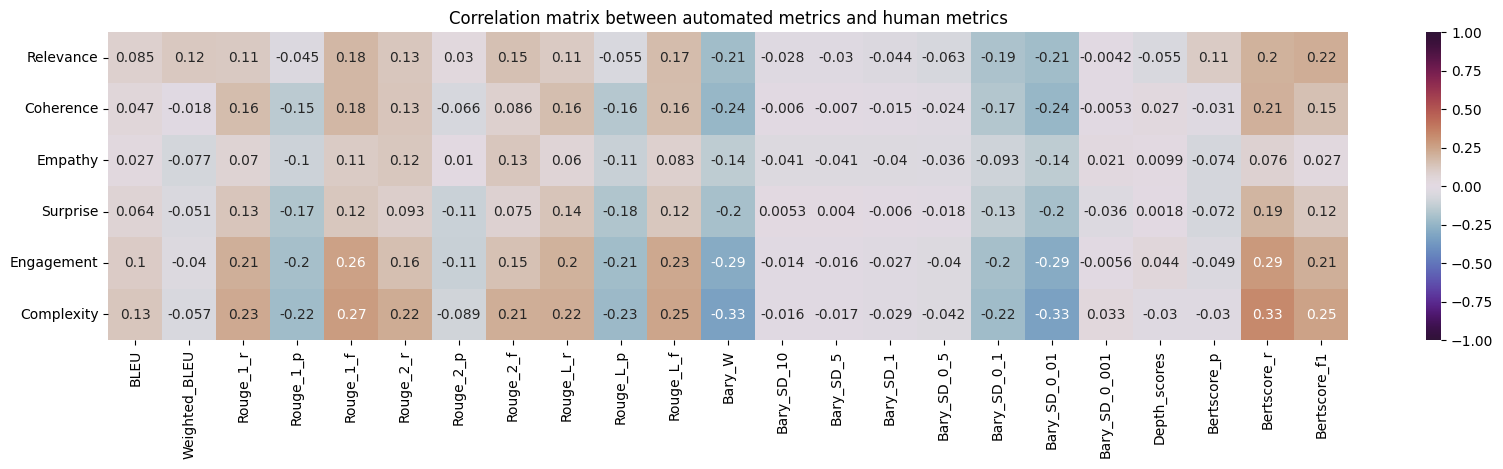

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_correlations(data, human_metrics):
    # Création d'un DataFrame à partir des données d'entrée
    df = pd.DataFrame(data)
    
    # Sélection des colonnes de métriques humaines
    df_human_metrics = df[human_metrics]
    
    # Calcul des corrélations entre toutes les colonnes et les métriques humaines
    correlations = df.corr().filter(human_metrics).drop(human_metrics)
    
    # Transposition de la matrice de corrélation
    correlations = correlations.T
    
    # Affichage de la matrice de corrélation transposée sous forme de heatmap avec des couleurs plus vives
    plt.figure(figsize=(20, 4))
    sns.heatmap(correlations, annot=True, cmap="twilight_shifted", vmin=-1, vmax=1)
    plt.title("Correlation matrix between automated metrics and human metrics")
    save_path= save_path = os.path.join('figures', f"HANNA_correlation.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()


# Remplacez 'data' par le nom de votre DataFrame contenant les données de votre dataset
human_metrics = ["Relevance", "Coherence", "Empathy", "Surprise", "Engagement", "Complexity"]
calculate_correlations(dfn, human_metrics)


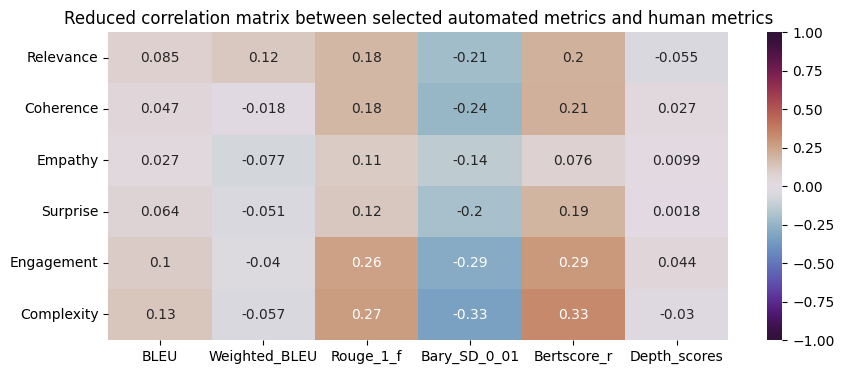

In [80]:
def calculate_reduced_correlations(data, human_metrics):
    df = pd.DataFrame(data)
    df_human_metrics = df[human_metrics]
    correlations = df.corr().filter(human_metrics).drop(human_metrics)
    correlations = correlations.T

    # Sélection des métriques les plus corrélées
    rouge_metrics = ["Rouge_1_r", "Rouge_1_p", "Rouge_1_f", "Rouge_2_r", "Rouge_2_p", "Rouge_2_f", "Rouge_L_r", "Rouge_L_p", "Rouge_L_f"]
    bary_metrics = ["Bary_SD_10", "Bary_SD_5", "Bary_SD_1", "Bary_SD_0_5", "Bary_SD_0_1", "Bary_SD_0_01", "Bary_SD_0_001"]
    bert_metrics = ["Bertscore_p", "Bertscore_r", "Bertscore_f1"]

    def select_most_correlated_metric(metric_list):
        mean_abs_correlations = correlations[metric_list].abs().mean()
        most_correlated_metric = mean_abs_correlations.idxmax()
        return most_correlated_metric

    selected_metrics = [
        "BLEU",
        "Weighted_BLEU",
        select_most_correlated_metric(rouge_metrics),
        select_most_correlated_metric(bary_metrics),
        select_most_correlated_metric(bert_metrics),
        "Depth_scores",
    ]

    # Création de la matrice de corrélation réduite
    reduced_correlations = correlations[selected_metrics]

    # Affichage de la matrice de corrélation réduite sous forme de heatmap
    plt.figure(figsize=(10, 4))
    sns.heatmap(reduced_correlations, annot=True, cmap="twilight_shifted", vmin=-1, vmax=1)
    plt.title("Reduced correlation matrix between selected automated metrics and human metrics")
    save_path = os.path.join("figures", f"HANNA_reduced_correlation.png")
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()


human_metrics = ["Relevance", "Coherence", "Empathy", "Surprise", "Engagement", "Complexity"]
calculate_reduced_correlations(dfn, human_metrics)
